In [59]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils
import matplotlib.animation as animation
from IPython.display import HTML
import cv2

In [60]:
class Critic(nn.Module):
  def __init__(self, channels_img, features_d):
    super(Critic, self).__init__()
    self.critic = nn.Sequential(
        #input: N x channels_img x 64 x 64
        nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
        nn.LeakyReLU(0.2),

        #self._block(self, in_channels, out_channels, kernel_size, stride, padding)
        self._block(features_d, features_d * 2, 4, 2, 1),
        self._block(features_d * 2, features_d * 4, 4, 2, 1),
        self._block(features_d * 4, features_d * 8, 4, 2, 1),

        #After all _block image size is 4x4 (convolution below make it into a 1x1)
        nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0)
    )


  def _block(self, in_channels, out_channels, kernel_size, stride, padding):
    return nn.Sequential(
        nn.Conv2d(
          in_channels,
          out_channels,
          kernel_size,
          stride,
          padding,
          bias=False
        ),
        nn.InstanceNorm2d(out_channels, affine=True),
        nn.LeakyReLU(0.2)   
      )
    
  def forward(self, x):
    return self.critic(x)

In [61]:
class Generator(nn.Module):
  def __init__(self,  z_dim, channels_img, features_g):
    super(Generator, self).__init__()
    self.gen = nn.Sequential(
        #input: N x z_dim x 1 X 1
        #self._block(self, in_channels, out_channels, kernel_size, stride, padding)
        self._block(z_dim, features_g * 16, 4, 1, 0),
        self._block(features_g * 16, features_g * 8, 4, 2, 1),
        self._block(features_g * 8, features_g * 4, 4, 2, 1),
        self._block(features_g * 4, features_g * 2, 4, 2, 1),

        nn.ConvTranspose2d(features_g * 2, channels_img, kernel_size=4, stride=2, padding=1),

        #Output: img N x channels_img x 64 x 64

        nn.Tanh() #[-1, 1]
    )


  def _block(self, in_channels, out_channels, kernel_size, stride, padding):
    return nn.Sequential(
      nn.ConvTranspose2d(
        in_channels,
        out_channels,
        kernel_size,
        stride,
        padding,
        bias=False
      ),
      nn.BatchNorm2d(out_channels),
      nn.ReLU()   
  )
    
  def forward(self, x):
    return self.gen(x)

In [62]:
def initialize_weights(model):
  for m in model.modules():
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
      nn.init.normal_(m.weight.data, 0.0, 0.02)

In [63]:
def test():
  N, in_channels, H, W = 8, 3, 64, 64
  z_dim = 100
  x = torch.randn((N, in_channels, H, W))

  critic = Critic(in_channels, 8)
  initialize_weights(critic)
  assert critic(x).shape == (N, 1, 1, 1), "Critic test failed"
  print("Critic test successfull")

  gen = Generator(z_dim, in_channels, 8)
  initialize_weights(gen)
  z = torch.randn((N, z_dim, 1, 1))
  assert gen(z).shape == (N, in_channels, H, W), "Generator test failed"
  print("Generator test successfull")
  print("Test succesfull")

In [93]:
def gradient_penalty(critic, real, fake, device):
  BATCH_SIZE, C, H, W = real.shape
  epsilon = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    
  interpolated_images = real * epsilon + fake * (1 - epsilon)


  #Calculate Critic scores
  mixed_scores = critic(interpolated_images)

  gradient = torch.autograd.grad(
      inputs=interpolated_images,
      outputs=mixed_scores,
      grad_outputs=torch.ones_like(mixed_scores),
      create_graph=True,
      retain_graph=True
  )[0]
  
  gradient = gradient.view(gradient.shape[0], -1)
  gradient_norm = gradient.norm(2, dim=1)
  gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
  
  return gradient_penalty

In [65]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [66]:
LEARNING_RATE_GEN = 1e-4  # could also use two lrs, one for gen and one for critic
LEARNING_RATE_CRITIC = 1e-4 
BATCH_SIZE = 64
IMAGE_SIZE = 64
CHANNELS_IMG = 3
Z_DIM = 100
NUM_EPOCHS = 10
FEATURES_CRITIC = 64
FEATURES_GEN = 64
CRITIC_ITERATIONS = 5
LAMBDA_GP = 10

In [67]:
transform = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)])
    ]
)

In [68]:
DATAROOT = "C:/Users/Aleksa/base_portrait"

dataset = datasets.ImageFolder(root=DATAROOT, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [69]:
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN)
critic = Critic(CHANNELS_IMG, FEATURES_CRITIC)
gen.to(device)
critic.to(device)

Critic(
  (critic): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (5): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2))
  )
)

In [70]:
initialize_weights(gen)
initialize_weights(critic)
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE_GEN, betas=(0.0, 0.9))
opt_critic = optim.Adam(critic.parameters(), lr=LEARNING_RATE_CRITIC, betas=(0.0, 0.9))
fixed_noise = torch.randn(32,Z_DIM, 1, 1).to(device)
writer_real = SummaryWriter(f"logs/real")
writer_fake = SummaryWriter(f"logs/fake")
step = 0
gen.train()
critic.train()

Critic(
  (critic): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (5): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2))
  )
)

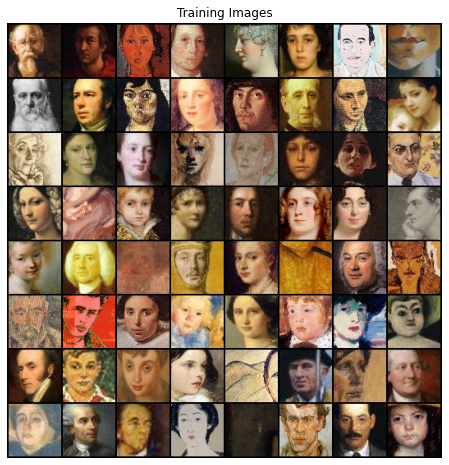

In [71]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [72]:
z = torch.randn(64, Z_DIM, 1, 1).to(device)

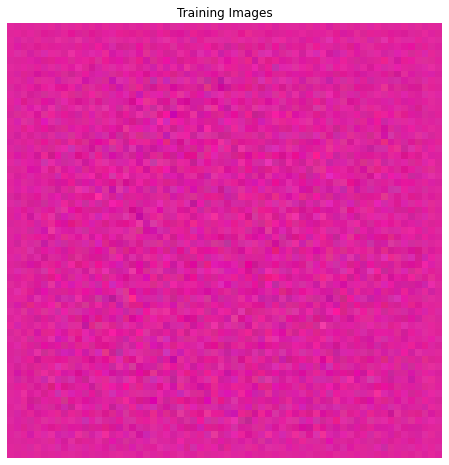

In [73]:
fake_batch = gen(z)
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(fake_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [74]:
img_list = []
G_losses = []
D_losses = []
iters = 0
img_list_fixed = []
fixed_noise = torch.randn(64, 100, 1, 1, device=device)

In [97]:
len(dataloader)

192

In [ ]:
for epoch in range(NUM_EPOCHS):

  z_test = torch.randn(64, Z_DIM, 1, 1).to(device)
  fake_batch_test = gen(z_test)
  plt.figure(figsize=(8,8))
  plt.axis("off")
  plt.title("Training Images")
  plt.imshow(np.transpose(vutils.make_grid(fake_batch_test[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

  for batch_index, (real, _) in enumerate(dataloader):
    if batch_index < len(dataloader) - 1:
      real = real.to(device)
      z = torch.randn(BATCH_SIZE, Z_DIM, 1, 1).to(device)
      fake = gen(z)

      for _ in range (CRITIC_ITERATIONS):
          z = torch.randn(BATCH_SIZE, Z_DIM, 1, 1).to(device)
          fake = gen(z)

          critic_real = critic(real).reshape(-1)
          critic_fake = critic(fake.detach()).reshape(-1)

          gp = gradient_penalty(critic, real, fake, device)
          
          loss_critic = -(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP * gp

          critic.zero_grad()
          loss_critic.backward(retain_graph=True)
          opt_critic.step()

      output = critic(fake).reshape(-1)
      loss_gen = -torch.mean(output)

      gen.zero_grad()
      loss_gen.backward()
      opt_gen.step()
    
      G_losses.append(loss_gen.item())
      D_losses.append(loss_critic.item())
    
      if (iters % 100 == 0) or ((epoch == NUM_EPOCHS-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = gen(z).detach().cpu()
                fake_fixed = gen(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            img_list_fixed.append(vutils.make_grid(fake_fixed, padding=2, normalize=True))
      if batch_index % 100 == 0:
        print(f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_index}/{int(len(dataloader) / BATCH_SIZE) * BATCH_SIZE} \ Loss D: {loss_critic:.4f}, loss G: {loss_gen:.4f}")
      
      iters+=1

Epoch [0/10] Batch 0/192 \ Loss D: -20.2161, loss G: 108.7404
Epoch [0/10] Batch 100/192 \ Loss D: -16.8592, loss G: 103.5001
Epoch [1/10] Batch 0/192 \ Loss D: -17.9238, loss G: 103.9059
Epoch [1/10] Batch 100/192 \ Loss D: -17.4938, loss G: 111.7901
Epoch [2/10] Batch 0/192 \ Loss D: -15.2366, loss G: 102.2914
Epoch [2/10] Batch 100/192 \ Loss D: -13.4572, loss G: 111.4345
Epoch [3/10] Batch 0/192 \ Loss D: -14.7025, loss G: 104.6738
Epoch [3/10] Batch 100/192 \ Loss D: -12.6133, loss G: 113.0962
Epoch [4/10] Batch 0/192 \ Loss D: -14.7518, loss G: 112.3080
Epoch [4/10] Batch 100/192 \ Loss D: -13.8425, loss G: 112.2295


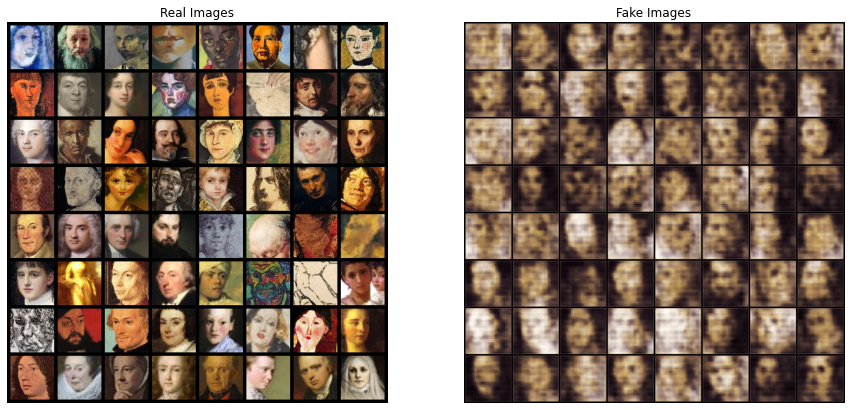

In [78]:
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

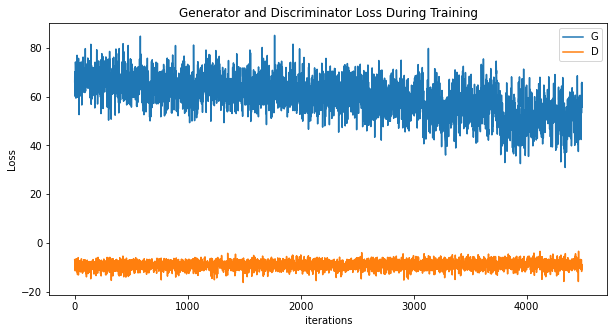

In [50]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [53]:
for i in range(1,101):
    image = np.transpose(img_list_fixed[-1*i],(1,2,0))
    image = image*255
    image  = image.cpu().numpy() # make sure tensor is on cpu
    image2 = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    cv2.imwrite('C:/Users/Aleksa/WGANgenerisane_fixed/'+str(i)+'.jpg', image2)

IndexError: list index out of range

In [58]:
torch.save(Critic, "C:/Users/Aleksa/Dmodel/")

PermissionError: [Errno 13] Permission denied: 'C:/Users/Aleksa/Dmodel/'